In [1]:
### Import statements
import os
import json
import csv
import pandas as pd
import sqlite3 as sql
from collections import namedtuple
import sklearn
import sklearn.linear_model
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
import seaborn as sns
import sklearn.pipeline
import sklearn.impute
import sklearn.compose
from sklearn.model_selection import train_test_split

In [2]:
### Data Entry
teams = pd.read_csv("nfl_teams.csv")
scores = pd.read_csv("spreadspoke_scores.csv")
stats = pd.read_csv("nfl_team_stats_2002-2022.csv")

In [3]:
#Create dictionaries mapping each team to their ID and division
team_dict = teams[["team_name", "team_id"]].set_index('team_name').to_dict()["team_id"]
division_dict = teams[["team_name", "team_division"]].set_index('team_name').to_dict()["team_division"]

In [4]:
### Creating new columns
win_margin_list = []
winner_list = []
winner_id_list = []
for idx in range(len(scores)):
    current_score = scores.iloc[idx]
    if current_score["score_home"] > current_score["score_away"]:
        win_margin_list.append(current_score["score_home"] - current_score["score_away"])
        winner_list.append('HOME')
        winner_id_list.append(team_dict[current_score['team_home']])
    elif current_score["score_home"] == current_score["score_away"]:
        win_margin_list.append(current_score["score_home"] - current_score["score_away"])
        winner_list.append('TIE')
        winner_id_list.append("TIE")
    else:
        win_margin_list.append(current_score["score_away"] - current_score["score_home"])
        winner_list.append('AWAY')
        winner_id_list.append(team_dict[current_score['team_away']])
        
### How much the winner won by
scores["win_margin"] = win_margin_list
### If the winner was home or away
scores['winner'] = winner_list
### ID of the winning team
scores['winner_id'] = winner_id_list

In [5]:
### Creating boolean column based on if the matchup was between two teams in the same division
division_list = []
for idx in range(len(scores)):
    current_score = scores.iloc[idx]
    home = current_score["team_home"]
    away = current_score["team_away"]
    if home in division_dict and away in division_dict:
        if division_dict[home] == division_dict[away]:
            division_list.append(True)
        else:
            division_list.append(False)
    else:
        division_list.append(False)
scores["divisional"] = division_list

In [6]:
### Creating column stating if the favorite is the home or away team
favorite_list = []
for idx in range(len(scores)):
    current_score = scores.iloc[idx]
    if current_score['team_favorite_id'] == team_dict[current_score['team_home']]:
        favorite_list.append('HOME')
    else:
        favorite_list.append('AWAY')
scores["favorite"] = favorite_list

In [7]:
### Creating new columns
cover_list = []
cover_margin_list = []
for idx in range(len(scores)):
    current_score = scores.iloc[idx]
    if current_score['winner'] == current_score['favorite']:
        if current_score['win_margin'] > abs(current_score['spread_favorite']):
            cover_list.append("COVER")
            cover_margin_list.append(current_score['win_margin'] - abs(current_score['spread_favorite']))
        elif current_score['win_margin'] == abs(current_score['spread_favorite']):
            cover_list.append("PUSH")
            cover_margin_list.append(0)
        else:
            cover_list.append("NO COVER")
            cover_margin_list.append(current_score['win_margin'] - abs(current_score['spread_favorite']))
    elif current_score['winner'] == "TIE":
        cover_list.append("NO COVER")
        cover_margin_list.append(current_score['win_margin'] - abs(current_score['spread_favorite']))
    else:
        cover_list.append("UPSET")
        cover_margin_list.append(-current_score['win_margin'] - abs(current_score['spread_favorite']))
### Four options: "COVER", "NO COVER", "PUSH", "UPSET"
scores['result'] = cover_list
### How much the final difered from the spread
# NOTE: Positive if favorite covered, negative if they did not
scores['cover_margin'] = cover_margin_list

In [8]:
cover_result_list = []
for idx in range(len(scores)):
    current_score = scores.iloc[idx]
    if current_score['result'] == "COVER" or current_score['result'] == "PUSH":
        cover_result_list.append("COVER")
    else:
        cover_result_list.append("NO COVER")

### Two options: "COVER", "NO COVER"
# NOTE: Pushes are considered as covers
scores['cover'] = cover_result_list

In [9]:
columns = stats.columns[3:]
###Extracting penalty yards and making that the penalty column
stats["penalties_home"] = stats["penalties_home"].str.split('-').str.get(1).astype(int)
stats["penalties_away"] = stats["penalties_away"].str.split('-').str.get(1).astype(int)

In [10]:
### Eliminating games from before 2002 (when stats data started)
scores = scores[scores["schedule_season"] >= 2002]

### Creating a dict for each year, mapping each team to a list of each of their statistical outputs by game
### Each team has a list for themselves and for what they allowed to their opponent for each stat
stats_dict = {}
for index, row in stats.iterrows():
    if int(row["date"][-5:-3]) > 2:
        year = int(row["date"][0:4])
    else:
        year = int(row["date"][0:4]) - 1
    if year < 2023:
        if year not in stats_dict:
            stats_dict[year] = {}
            year_d = stats_dict[year] 
        if row["home"] not in year_d:
            year_d[row["home"]] = {}
        if row["away"] not in year_d:
            year_d[row["away"]] = {}
        home_dict = year_d[row["home"]]
        away_dict = year_d[row["away"]]
        for column in columns:
            if column[:-5] not in home_dict:
                home_dict[column[:-5]] = []
                home_dict[column[:-5]+"_allowed"] = []
            if column[:-5] not in away_dict:
                away_dict[column[:-5]] = []
                away_dict[column[:-5]+"_allowed"] = []
            if column[-4:] == "home":
                home_dict[column[:-5]].append(row[column])
                away_dict[column[:-5]+"_allowed"].append(row[column])
            else:
                away_dict[column[:-5]].append(row[column])
                home_dict[column[:-5]+"_allowed"].append(row[column])

In [11]:
### divide any column formatted as a fraction into a float
def div(item):
    try:
        return int(item.split('-')[0])/int(item.split('-')[1])
    except:
        return 0
        
### convert possession into a float of minutes
def possession(time):
    return int(time[0:2]) + int(time[3:]) / 60

### Gather the mean for every statsitic for each team by year
for year in stats_dict:
    for team in stats_dict[year]:
        for stat in stats_dict[year][team]:
            stat_list = stats_dict[year][team][stat]
            if type(stat_list[0]) == int:
                stats_dict[year][team][stat] = mean(stat_list)
            elif type(stat_list[0]) == str:
                if stat_list[0][2] == ":":
                    stats_dict[year][team][stat] = mean([possession(time) for time in stat_list])
                else:
                    stats_dict[year][team][stat] = mean([div(item) for item in stat_list])
                


In [12]:
### Add the mean yearly statsitcs of the home and away team for each game played in scores
def apply_stats(df, dic):
    stats_list = []
    for index, row in df.iterrows():
        game_dict = {}
        year = row["schedule_season"]
        home = row["team_home"].split()[-1]
        away = row["team_away"].split()[-1]
        home_stat = dic[year][home]
        away_stat = dic[year][away]
        for stat in home_stat:
            game_dict["home_"+stat] = home_stat[stat]
        for stat in away_stat:
            game_dict["away_"+stat] = away_stat[stat]
        stats_list.append(game_dict)
    return pd.DataFrame(stats_list)


### Accounting for Washington name changes since 2002 (stats_dict considers them Commanders every year)
scores["team_home"] = np.where(scores["team_home"] == "Washington Redskins", "Washington Commanders", scores["team_home"])
scores["team_away"] = np.where(scores["team_away"] == "Washington Redskins", "Washington Commanders", scores["team_away"])
scores["team_home"] = np.where(scores["team_home"] == "Washington Football Team", "Washington Commanders", scores["team_home"])
scores["team_away"] = np.where(scores["team_away"] == "Washington Football Team", "Washington Commanders", scores["team_away"])

In [13]:
###Formatting
scores = scores.reset_index()
scores = scores.drop(labels = "index", axis = 1)

In [14]:
### Creating dict where first level is team and second is year instead of stats_dict (which is vice versa)
def team_dict(dct):
    team_dict = {}
    for year in dct:
        for team in dct[year]:
            if team not in team_dict:
                team_dict[team] = {}
            team_dict[team][year] = dct[year][team]
    return team_dict
            
team_stat_dict = team_dict(stats_dict)

In [15]:
### Renaming columns in df to reflect favorite and underdog instead of home or away
# If the home team is favored
def home_fav(column):
    if "home" in column:
        return column.replace("home", 'fav')
    elif 'away' in column:
        return column.replace('away', 'ud')
    else:
        return column
    
# If the away team is favored
def away_fav(column):
    if "home" in column:
        return column.replace("home", 'ud')
    elif 'away' in column:
        return column.replace('away', 'fav')
    else:
        return column

,team_home,team_away,team_favorite_id,favorite
0,New York Giants,San Francisco 49ers,SF,AWAY
1,Buffalo Bills,New York Jets,NYJ,AWAY
2,Carolina Panthers,Baltimore Ravens,PICK,AWAY
3,Chicago Bears,Minnesota Vikings,CHI,HOME
4,Cincinnati Bengals,San Diego Chargers,CIN,HOME
...,...,...,...,...
5639,Buffalo Bills,Cincinnati Bengals,BUF,HOME
5640,San Francisco 49ers,Dallas Cowboys,SF,HOME
5641,Kansas City Chiefs,Cincinnati Bengals,KC,HOME
5642,Philadelphia Eagles,San Francisco 49ers,PHI,HOME


In [16]:
### Create df with the home and away stats for each gane
stat_df = apply_stats(scores, stats_dict)

### Merge stat_df with scores
scores = scores.merge(stat_df, left_index = True, right_index = True)

### Renaming the columns to identify favorite and underdog instead of home and away
home_favorites = scores[scores["favorite"] == "HOME"]    
home_favorites.rename(columns=lambda col: home_fav(col), inplace=True)
away_favorites = scores[scores["favorite"] == "AWAY"]    
away_favorites.rename(columns=lambda col: away_fav(col), inplace=True)
scores = home_favorites.append(away_favorites)
scores = scores.sort_index()

/tmp/ipykernel_2545531/2830073368.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_favorites.rename(columns=lambda col: home_fav(col), inplace=True)
/tmp/ipykernel_2545531/2830073368.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  away_favorites.rename(columns=lambda col: away_fav(col), inplace=True)
/tmp/ipykernel_2545531/2830073368.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = home_favorites.append(away_favorites)


In [17]:
### Creating shortcut to identifying stats (fav, ud, fav_allowed, ud_allowed)
def stat(stat):
    return ["fav_"+stat, "fav_"+stat+"_allowed", "ud_"+stat, "ud_"+stat+"_allowed"]

['fav_pheen',
 'fav_pheen_allowed',
 'ud_pheen',
 'ud_pheen_allowed',
 'fav_grunt',
 'fav_grunt_allowed',
 'ud_grunt',
 'ud_grunt_allowed']

In [18]:
### Creating a list of each team's record against the spread at the point of each game being played
# NOTE: Pushes are considered as covers 
def ats(df):
    ats_dict = {}
    ats_fav_list = []
    ats_ud_list = []
    for index, row in df.iterrows():
        fav = row["team_fav"]
        ud = row["team_ud"]
        year = row["schedule_season"]
        if year not in ats_dict:
            ats_dict[year] = {}
        if fav not in ats_dict[year]:
            ats_dict[year][fav] = []
        if ud not in ats_dict[year]:
            ats_dict[year][ud] = []
        if row["cover"] == "COVER":
            ats_dict[year][fav].append(1)
            ats_dict[year][ud].append(0)
        else:
            ats_dict[year][fav].append(0)
            ats_dict[year][ud].append(1)
        if len(ats_dict[year][fav]) == 1:
            ats_fav_list.append(0)
        else:
            ats_fav_list.append(mean(ats_dict[year][fav][:-1]))
        if len(ats_dict[year][ud]) == 1:
            ats_ud_list.append(0)
        else:
            ats_ud_list.append(mean(ats_dict[year][ud][:-1]))
    return pd.DataFrame({"fav_ats": ats_fav_list, "ud_ats": ats_ud_list})

In [19]:
### Adding the ats statistics to scores
scores = pd.merge(scores, ats(scores), left_index = True, right_index = True)

In [20]:
### TEST: COVER OR NO COVER (WHat we are trying to accurately predict
y = scores["cover"]
### All other columns
x = scores.drop("cover", axis = 1)

### All continuous statistics being used (other than the ats)
cont1 = stat("score") + ["fav_turnovers", "ud_turnovers"] + stat("passing_yards") + stat("rushing_yards") + ["spread_favorite"]
### Continuous, but want to add extra transformer
cont2 = ["fav_ats", "ud_ats"]
### Discrete variables (True/False or Home/Away)
discrete = ["divisional", "favorite", "schedule_playoff"]
### Only gets interaction term of the ats stats (fav_ats*ud_ats)
transformer_c1 = sklearn.preprocessing.PolynomialFeatures(include_bias = False, interaction_only = True)
### Scales all continuous variables to have mean of 0 and standard deviation of 1
transformer_c2 = sklearn.preprocessing.StandardScaler()
### Creates a new column for each categorical option, with all entries treated as 1 or 0 whether that is true or fale
transformer_d = sklearn.preprocessing.OneHotEncoder()
steps_c1 = sklearn.pipeline.Pipeline(steps = [(("tc2", transformer_c2))])
steps_d = sklearn.pipeline.Pipeline(steps = [(("td", transformer_d))])
steps_c2 = sklearn.pipeline.Pipeline(steps = [("tc2", transformer_c2), ("tc1", transformer_c1)])
pre = sklearn.compose.ColumnTransformer(transformers = [("d", steps_d, discrete), ("c1", steps_c1, cont1), ("c2", steps_c2, cont2)])
### Utilizing a logistic regression model
model = sklearn.pipeline.Pipeline(steps = [("pre", pre), ("clf", sklearn.linear_model.LogisticRegression())])
model



Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('d',
                                                  Pipeline(steps=[('td',
                                                                   OneHotEncoder())]),
                                                  ['divisional', 'favorite',
                                                   'schedule_playoff']),
                                                 ('c1',
                                                  Pipeline(steps=[('tc2',
                                                                   StandardScaler())]),
                                                  ['fav_score',
                                                   'fav_score_allowed',
                                                   'ud_score',
                                                   'ud_score_allowed',
                                                   'fav_turnovers',
                                                   'ud_turnovers',
                                                   'fav_passing_yards',
                                                   'fav_passing_yards_allowed',
                                                   'ud_passing_yards',
                                                   'ud_passing_yards_allowed',
                                                   'fav_rushing_yards',
                                                   'fav_rushing_yards_allowed',
                                                   'ud_rushing_yards',
                                                   'ud_rushing_yards_allowed',
                                                   'spread_favorite']),
                                                 ('c2',
                                                  Pipeline(steps=[('tc2',
                                                                   StandardScaler()),
                                                                  ('tc1',
                                                                   PolynomialFeatures(include_bias=False,
                                                                                      interaction_only=True))]),
                                                  ['fav_ats', 'ud_ats'])])),
                ('clf', LogisticRegression())])

In [21]:
### Cross Validation Score
sklearn.model_selection.cross_val_score(model, x, y, cv = 5).mean()

0.6509535834762452

In [22]:
### Accuracy of Model based on Confusion Matrix
model.fit(x, y)
y_pred = model.predict(x)
matrix = sklearn.metrics.confusion_matrix(y, y_pred)
(matrix[0, 0] + matrix[1, 1]) / matrix.sum()


0.6537916371367825

In [23]:
### Adding prediction (results) to scores
results = pd.concat([y.reset_index(), pd.Series(y_pred)], axis = 1)
scores = pd.merge(scores, results, left_index = True, right_index = True)

In [24]:
### Formatting
scores = scores.drop("cover_x", axis = 1)
scores["cover"] = scores["cover_y"]
scores["pred"] = scores[0]
scores = scores.drop(["cover_y", 0], axis = 1)

In [25]:
### Column showing if prediction was correct or not
correct_list = []
for index, row in scores.iterrows():
    if row["cover"] == row["pred"]:
        correct_list.append(True)
    else:
        correct_list.append(False)
        
scores["correct"] = correct_list

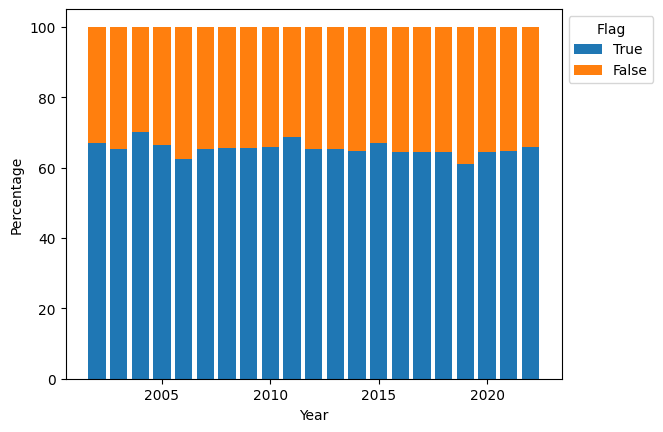

In [26]:
# Accuracy graph by year
counts = scores.groupby(['schedule_season', 'correct']).size().unstack(fill_value=0)

percentage = counts.div(counts.sum(axis=1), axis=0) * 100

percentage = pd.DataFrame([percentage.iloc[:,1], percentage.iloc[:, 0]]).transpose()
for correct in percentage.columns:
    plt.bar(percentage.index, percentage[correct], label=correct, bottom=percentage.iloc[:, :percentage.columns.get_loc(correct)].sum(axis=1))

plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend(title='Flag', bbox_to_anchor=(1, 1))

plt.show()

In [ ]:
### Creating Flask Wesbite for Inputting Stats and Recieveing a Predicton
from flask import Flask, request, redirect, jsonify, Response, render_template
app = Flask("app")

### Home page
# Recieves home team and away team
# Goes to info when form is submitted
@app.route("/", methods=["GET", "POST"])
def index():
    global fav, ud
    fav = None
    ud = None
    if request.method == 'POST':
        fav = (request.form["fav"]).split()[-1]
        ud = (request.form["ud"]).split()[-1]
        return render_template('info.html', fav=fav, ud=ud)
    return render_template('website.html')

prev = []
###Page to input stats
# Provides a link to statmuse for each statistic
# Goes to page with prediction when form is submitted
# Also return list of previous predictions
@app.route("/info", methods=["GET", "POST"])
def info():
### All variables
    spread = None
    ha = None
    div = None
    p = None
    f_score = None
    f_scorea = None
    f_py = None
    f_pya = None
    f_ry = None
    f_rya = None
    f_to = None
    f_ats = None
    u_score = None
    u_scorea = None
    u_py = None
    u_pya = None
    u_ry = None
    u_rya = None
    u_to = None
    u_ats = None
### Getting vatiables from form
    if request.method == 'POST':
        spread = request.form["spread"]
        ha = request.form["ha"]
        div = request.form["div"]
        p = request.form["p"]
        f_score = request.form["f_score"]
        f_scorea = request.form["f_scorea"]
        f_py = request.form["f_py"]
        f_pya = request.form["f_pya"]
        f_ry = request.form["f_ry"]
        f_rya = request.form["f_rya"]
        f_to = request.form["f_to"]
        f_ats = request.form["f_ats"]
        u_score = request.form["u_score"]
        u_scorea = request.form["u_scorea"]
        u_py = request.form["u_py"]
        u_pya = request.form["u_pya"]
        u_ry = request.form["u_ry"]
        u_rya = request.form["u_rya"]
        u_to = request.form["u_to"]
        u_ats = request.form["u_ats"]
### Formatting ats record to ats percentage
        def ats(ats):
            split = [int(num) for num in ats.split('-')]
            if len(split) == 3:
                return (split[0] + split[2]) / sum(split)
            else:
                return (split[0] / sum(split))
        f_ats = ats(f_ats)
        u_ats = ats(u_ats)
### Changing all T/F to boolean 
        if div == "True":
            div = True
        else:
            div = False
        if p == "True":
            p = True
        else:
            p = False
            
### Creating df to input into model
        df = pd.DataFrame(pd.Series({
        "divisional": div,
        "favorite": ha,
        "schedule_playoff": p,
        'fav_score': float(f_score),
        'fav_score_allowed': float(f_scorea),
        'ud_score': float(u_score),
        'ud_score_allowed': float(u_scorea),
        'fav_turnovers': float(f_to),
        'ud_turnovers': float(u_to),
        'fav_passing_yards': float(f_py),
        'fav_passing_yards_allowed': float(f_pya),
        'ud_passing_yards': float(u_py),
        'ud_passing_yards_allowed': float(u_pya),
        'fav_rushing_yards': float(f_ry),
        'fav_rushing_yards_allowed': float(f_rya),
        'ud_rushing_yards': float(u_ry),
        'ud_rushing_yards_allowed': float(u_rya),
        'spread_favorite': float(spread),
        'fav_ats': float(f_ats),
        'ud_ats': float(u_ats)      
        })).transpose()
        prediction = model.predict(df)[0]
        prev.append(f"{fav} ({spread}) vs {ud} --> {prediction}")
        html = "<ul>\n"
        for item in prev[:-1]:
            html += f"  <li>{item}</li>\n"
        html += "</ul>"
        return f"<h1>{fav} ({spread}) vs {ud} --> {prediction}</h1><br><br><h3>Previous:{html}</h3>"
    return render_template('info.html', fav=fav, ud=ud)
app.run(host = "0.0.0.0", debug = False, threaded = False)

 * Serving Flask app 'app'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://10.128.0.2:5000
Press CTRL+C to quit
205.210.31.148 - - [08/Jan/2024 21:25:10] "GET / HTTP/1.0" 200 -
